In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, regularizers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math, random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from arch import arch_model
import time
import math
import matplotlib.pyplot as plt
import os
import pickle
import json

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)

plt.style.use("seaborn-v0_8")

In [2]:
px_common = pd.read_csv(r"E:\data\stock_prices.csv", index_col="date", parse_dates=True)

In [ ]:
VAL_START, VAL_END = "2023-07-01", "2023-12-31"
TEST_START = "2024-01-01"

mask_train = px_common.index < VAL_START
mask_val   = (px_common.index >= VAL_START) & (px_common.index <= VAL_END)
mask_test  = px_common.index >= TEST_START

X_train = px_common.loc[mask_train]
X_val   = px_common.loc[mask_val]
X_test  = px_common.loc[mask_test]

# =====================================================================
# 1) STANDARDIZATION (per asset)
# =====================================================================
scalers = {}
X_train_sc, X_val_sc, X_test_sc = X_train.copy(), X_val.copy(), X_test.copy()

for col in px_common.columns:
    sc = StandardScaler().fit(X_train[[col]])
    scalers[col] = sc
    X_train_sc[col] = sc.transform(X_train[[col]])
    X_val_sc[col]   = sc.transform(X_val[[col]])
    X_test_sc[col]  = sc.transform(X_test[[col]])

n_assets = X_train_sc.shape[1]

# =====================================================================
# 2) HELPER FUNCTIONS
# =====================================================================
def realized_vol_series(s, w=20):
    return s.rolling(w, min_periods=w).std()

def make_lags(s, k):
    return pd.concat([s.shift(i).rename(f"{s.name}_t-{i}") for i in range(1, k+1)], axis=1)

# =====================================================================
# 3) AUTO LAG SELECTION
# =====================================================================
px = px_common.copy()
rets_all = np.log(px).diff().dropna()
rets_med = rets_all.median(axis=1).rename("mret")

lag_grid = [1,3,5,7,10]
results_lags = []

for lag_r in lag_grid:
    for lag_v in lag_grid:
        lags_r = make_lags(rets_med, lag_r)
        vol20  = rets_med.rolling(20).std().rename("vol20")
        lags_v = make_lags(vol20, lag_v)

        feat = pd.concat([lags_r, lags_v], axis=1).dropna()
        y = px.iloc[1:].loc[feat.index]
        sc_y = StandardScaler()
        y_sc = sc_y.fit_transform(y)

        lr = LinearRegression()
        lr.fit(feat, y_sc)
        pred = lr.predict(feat)

        rmse = np.sqrt(mean_squared_error(y_sc, pred))
        results_lags.append([lag_r, lag_v, rmse])

results_lags_df = pd.DataFrame(results_lags, columns=["lags_r","lags_v","rmse"])
best_lags = results_lags_df.loc[results_lags_df.rmse.idxmin()]
best_lag_r = int(best_lags["lags_r"])
best_lag_v = int(best_lags["lags_v"])

print("Best Lags:", best_lags)

# =====================================================================
# 4) AUTO GARCH PER ASSET
# =====================================================================
garch_param_series = []
garch_cfg = []

P_CHOICES=[2]; Q_CHOICES=[2]

for col in px_common.columns:
    rets_col = np.log(px_common[col]).diff().dropna() * 100
    best_aic = np.inf
    best_p = best_q = None
    best_model = None

    for p in P_CHOICES:
        for q in Q_CHOICES:
            try:
                am = arch_model(rets_col, vol="Garch", p=p, q=q, dist="t")
                res = am.fit(update_freq=0, disp="off")
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_p, best_q = p, q
                    best_model = res
            except:
                pass

    params = best_model.params
    omega = params.get("omega", np.nan)
    alpha_sum = sum(v for k,v in params.items() if "alpha" in k)
    beta_sum  = sum(v for k,v in params.items() if "beta" in k)
    pers = alpha_sum + beta_sum

    idx = px_common.index
    garch_param_series.append(pd.Series(omega, idx, name=f"{col}_garch_omega"))
    garch_param_series.append(pd.Series(alpha_sum, idx, name=f"{col}_garch_alpha_sum"))
    garch_param_series.append(pd.Series(beta_sum, idx, name=f"{col}_garch_beta_sum"))
    garch_param_series.append(pd.Series(pers, idx, name=f"{col}_garch_persist"))

garch_static_df = pd.concat(garch_param_series, axis=1)

# =====================================================================
# 5) FEATURE ENGINEERING (USING OPTIMAL LAGS)
# =====================================================================
rets = np.log(px_common).diff().dropna()
rets_med = rets.median(axis=1).rename("mret")

lags_r = make_lags(rets_med, best_lag_r)
vol20 = realized_vol_series(rets_med, 20).rename("vol20")
lags_v = make_lags(vol20, best_lag_v)

vol_s = realized_vol_series(rets_med,5).rename("vol5")
q = vol_s.quantile([0.33,0.66])
reg = pd.DataFrame({
    "reg_low":  (vol_s <= q.iloc[0]).astype(int),
    "reg_mid": ((vol_s > q.iloc[0]) & (vol_s <= q.iloc[1])).astype(int),
    "reg_high":(vol_s > q.iloc[1]).astype(int)
})

px_dm = (px_common.mean(axis=1) - px_common.mean(axis=1).rolling(120,min_periods=30).mean()).rename("market_lvl_dm")
ema   = px_common.mean(axis=1).ewm(span=20,min_periods=10).mean().rename("market_ema20")

feat_df = pd.concat([lags_r,lags_v,reg,px_dm,ema,garch_static_df], axis=1).dropna()
# reindex to full px_common timeline, forward fill existing values and drop remaining NaNs
feat_df = feat_df.reindex(px_common.index).ffill().dropna()

# Use reindex instead of .loc to avoid KeyError when some train/val/test dates
# are earlier than the first available feature row.
# Forward-fill after reindex ensures there are no missing rows inside each split;
# we keep dropna above so initial dates before the first valid feature row are removed.
Z_train = feat_df.reindex(X_train_sc.index).ffill().dropna().values
Z_val   = feat_df.reindex(X_val_sc.index).ffill().dropna().values
Z_test  = feat_df.reindex(X_test_sc.index).ffill().dropna().values

# =====================================================================
# 6) TARGETS
# =====================================================================

X_df = px_common.iloc[:-1].copy() 
y_df = px_common.iloc[1:].copy()   
y_df.index = X_df.index            

mask_train = X_df.index < VAL_START
mask_val   = (X_df.index >= VAL_START) & (X_df.index <= VAL_END)
mask_test  = X_df.index >= TEST_START

y_train = y_df.loc[mask_train]
y_val   = y_df.loc[mask_val]
y_test  = y_df.loc[mask_test]

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# FIX: create scaled dataframes BEFORE applying transforms
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
y_train_sc = y_train.copy()
y_val_sc   = y_val.copy()
y_test_sc  = y_test.copy()

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Apply per-asset scaling
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
for col in px_common.columns:
    y_train_sc[col] = scalers[col].transform(y_train[[col]])
    y_val_sc[col]   = scalers[col].transform(y_val[[col]])
    y_test_sc[col]  = scalers[col].transform(y_test[[col]])


Xc_train, Xc_val, Xc_test = X_train_sc.values, X_val_sc.values, X_test_sc.values

# =====================================================================
# 7) ALIGN ALL ARRAYS (VERY IMPORTANT)
# =====================================================================
def align_arrays(Z, Xc, y):
    idx = min(len(Z), len(Xc), len(y))
    return Z[:idx], Xc[:idx], y.iloc[:idx]

Z_train, Xc_train, y_train_sc = align_arrays(Z_train, Xc_train, y_train_sc)
Z_val,   Xc_val,   y_val_sc   = align_arrays(Z_val,   Xc_val,   y_val_sc)
Z_test,  Xc_test,  y_test_sc  = align_arrays(Z_test,  Xc_test,  y_test_sc)

print("Aligned Shape (Train):", len(Z_train), len(Xc_train), len(y_train_sc))

# =====================================================================
# 8) MAKE SEQUENCES (SAFE)
# =====================================================================
SEQ_LEN = 20

def make_sequences_flat(Z, Xc, y, seq_len=20):
    X_seq, X_curr, Y = [], [], []
    T = len(Z)
    for i in range(seq_len, T):
        if i >= len(Xc) or i >= len(y): break
        window = Z[i-seq_len:i].reshape(-1)
        X_seq.append(window)
        X_curr.append(Xc[i])
        Y.append(y.iloc[i].values)
    return np.array(X_seq), np.array(X_curr), np.array(Y)

Z_train_seq, Xc_train_seq, y_train_seq = make_sequences_flat(Z_train, Xc_train, y_train_sc, SEQ_LEN)
Z_val_seq,   Xc_val_seq,   y_val_seq   = make_sequences_flat(Z_val,   Xc_val,   y_val_sc,   SEQ_LEN)
Z_test_seq,  Xc_test_seq,  y_test_seq  = make_sequences_flat(Z_test,  Xc_test,  y_test_sc,  SEQ_LEN)

print("Train seq:", Z_train_seq.shape)

# =====================================================================
# 9) SEQUENCE RESNET (bias-corrected)
# =====================================================================
def residual_block(x, units, drop=0.05):
    sc = x
    x = layers.Dense(units, activation= 'relu' , 
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers,Dropout(drop)(x)
    x = layers.Dense(units, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Add()([x, sc])
    return layers.Activation('relu')(x)

def build_sequence_resnet(input_dim, n_assets, n_blocks=1, hidden_units=155):
    inp_Z = Input(shape=(input_dim,))
    inp_curr = Input(shape=(n_assets,))
    x = layers.Dense(hidden_units, activation='relu')(inp_Z)
    for _ in range(n_blocks):
        x = residual_block(x, hidden_units)
    delta = layers.Dense(n_assets)(x)
    out = layers.Add()([inp_curr, delta])
    model = Model([inp_Z, inp_curr], out)
    model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                  loss=tf.keras.losses.Huber(delta=1.0))
    return model

model = build_sequence_resnet(Z_train_seq.shape[1], n_assets)


Best Lags: lags_r    10.000000
lags_v    10.000000
rmse       0.971212
Name: 24, dtype: float64
Aligned Shape (Train): 1353 1353 1353
Train seq: (1333, 1300)


Epoch 1/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5780 - val_loss: 3.0373 - learning_rate: 3.0000e-04
Epoch 2/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2093 - val_loss: 1.6455 - learning_rate: 3.0000e-04
Epoch 3/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1059 - val_loss: 0.9511 - learning_rate: 3.0000e-04
Epoch 4/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0879 - val_loss: 0.5831 - learning_rate: 3.0000e-04
Epoch 5/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0772 - val_loss: 0.4010 - learning_rate: 3.0000e-04
Epoch 6/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0700 - val_loss: 0.3174 - learning_rate: 3.0000e-04
Epoch 7/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0655 - val_loss: 0.2029 - learning_rate: 3.0000e-04
Epoch 8/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0625 - val_loss: 0.1620 - learning_rate: 3.0000e-04
Epoch 9/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0573 - val_loss: 0.1636 - learning_rate: 3.0

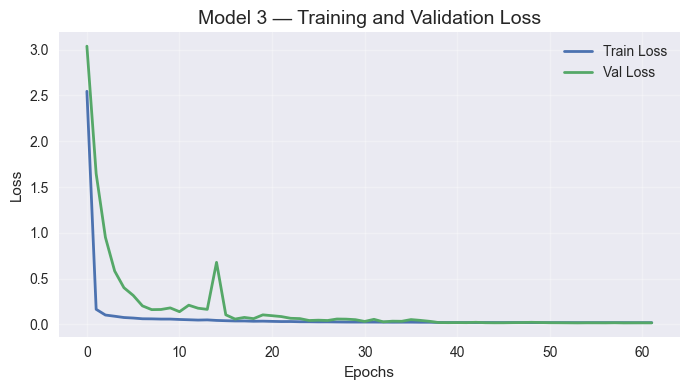


Training time: 9.15 seconds
Model size: 0.96 MB
Trainable parameters: 251,885


In [ ]:
# ==========================================================
# TRAINING TIME (FINAL FIT ONLY)
# ==========================================================
start_time = time.time()
hist = model.fit(
    [Z_train_seq, Xc_train_seq], y_train_seq,
    validation_data=([Z_val_seq, Xc_val_seq], y_val_seq),
    epochs=80, batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ],
    verbose=1
)

# =====================================================================
# TRAINING HISTORY PLOT (LOSS & VAL LOSS)
# =====================================================================
plt.figure(figsize=(7,4))
plt.plot(hist.history["loss"], label="Train Loss", lw=2)
plt.plot(hist.history["val_loss"], label="Val Loss", lw=2)
plt.title("Model 3 — Training and Validation Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

end_time = time.time()

print(f"\nTraining time: {end_time - start_time:.2f} seconds")


# ==========================================================
# MODEL SIZE (MEMORY FOOTPRINT)
# ==========================================================
def keras_model_size_mb(model):
    total_bytes = 0
    for w in model.trainable_weights:
        total_bytes += np.prod(w.shape) * 4  
    for w in model.non_trainable_weights:
        total_bytes += np.prod(w.shape) * 4
    return total_bytes / (1024**2)

print(f"Model size: {keras_model_size_mb(model):.2f} MB")

# ==========================================================
# NUMBER OF TRAINABLE PARAMETERS
# ==========================================================
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")

In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1300)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 155)       │    201,655 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 155)       │     24,180 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 155)       │        620 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 155)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 155)       │     24,180 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 155)       │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 155)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │      1,560 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10)        │          0 │ input_layer_1[0]… │
│                     │                   │            │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 755,967 (2.88 MB)

 Trainable params: 251,885 (983.93 KB)

 Non-trainable params: 310 (1.21 KB)

 Optimizer params: 503,772 (1.92 MB)


=== OVERALL TEST METRICS ===
RMSE (overall): 6.205
MAE  (overall): 3.851
R²   (overall): 0.999

=== Per-Asset Forecasting Metrics ===


,RMSE,MAE,R2
SCHD,0.579,0.462,0.770
VZ,0.727,0.538,0.920
XOM,2.494,1.966,0.758
PG,2.876,2.200,0.759
CVX,3.358,2.612,0.794
AVGO,6.776,4.543,0.988
AMZN,7.029,5.463,0.887
VOO,8.256,5.946,0.964
CAT,9.059,6.942,0.949
MSFT,10.624,7.835,0.931


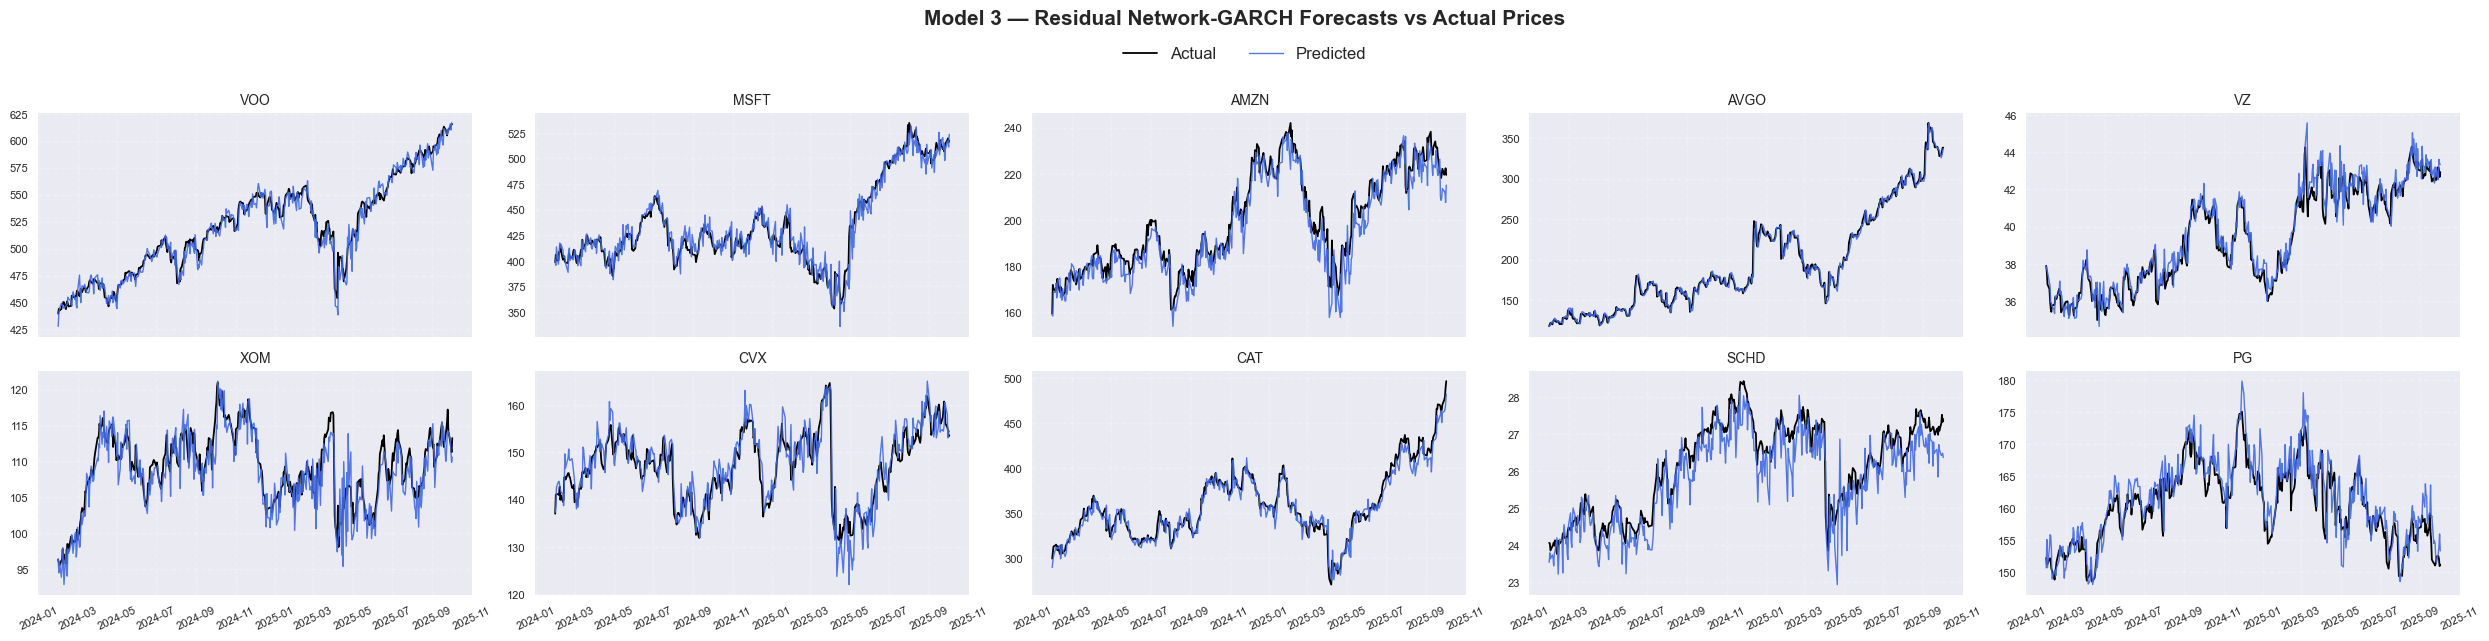

In [11]:
# =====================================================================
# 10) TEST PREDICTION
# =====================================================================
y_pred_sc = model.predict([Z_test_seq, Xc_test_seq], verbose=0)
test_idx = y_test_sc.index[SEQ_LEN:]
y_pred_df = pd.DataFrame(y_pred_sc, index=test_idx, columns=px_common.columns)

# inverse-scale
y_pred_real = y_pred_df.copy()
for col in px_common.columns:
    y_pred_real[col] = scalers[col].inverse_transform(y_pred_df[[col]])

y_test_real = y_test.loc[test_idx]

# ==========================================================
# OVERALL METRICS
# ==========================================================
y_true_all = y_test_real.values.flatten()
y_pred_all = y_pred_real.values.flatten()

overall_rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
overall_mae  = mean_absolute_error(y_true_all, y_pred_all)
overall_r2   = r2_score(y_true_all, y_pred_all)

print("\n=== OVERALL TEST METRICS ===")
print(f"RMSE (overall): {overall_rmse:.3f}")
print(f"MAE  (overall): {overall_mae:.3f}")
print(f"R²   (overall): {overall_r2:.3f}")

metrics_df = pd.DataFrame(index=px_common.columns, columns=["RMSE","MAE","R2"])

for col in px_common.columns:
    y_true = y_test_real[col].values
    y_pred = y_pred_real[col].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    metrics_df.loc[col,"RMSE"] = rmse
    metrics_df.loc[col,"MAE"]  = mae
    metrics_df.loc[col,"R2"]   = r2

# sorting by RMSE (best assets on top)
metrics_df = metrics_df.sort_values("RMSE")

print("\n=== Per-Asset Forecasting Metrics ===")
display(metrics_df.style.format("{:.3f}"))


# =====================================================================
# PLOTS FOR ALL ASSETS — Multi-panel Forecast Visualization
# =====================================================================
assets = px_common.columns
n_assets = len(assets)

ncols = 5
nrows = math.ceil(n_assets / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5*ncols, 3.2*nrows),
    sharex=True
)

axes = axes.ravel()

for i, col in enumerate(assets):
    ax = axes[i]
    ax.plot(y_test_real.index, y_test_real[col],color="black", lw=1.3, label="Actual")
    ax.plot(y_pred_real.index, y_pred_real[col],color="royalblue", lw=1., alpha=0.9, label="Predicted")
    ax.set_title(col, fontsize=10)
    ax.grid(True, alpha=0.25, linestyle="--")
    ax.tick_params(axis="x",rotation=25,labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

# remove extra axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center",bbox_to_anchor=(0.5, 0.96),ncol=2,frameon=False,fontsize=12)
fig.suptitle("Model 3 — Residual Network-GARCH Forecasts vs Actual Prices",fontsize=15,fontweight="bold",y=0.995)
plt.tight_layout(rect=[0,0,1,0.94])
plt.show()

In [7]:
print("\n================ MODEL 3 — SEQUENCE RESNET (COMMON DATA) ================")

# ---------------------------------------------------------------------
# 1) DATASET SPLIT
# ---------------------------------------------------------------------
print("\n[1] Dataset split (timesteps)")
print("Train :", X_train_sc.shape[0])
print("Val   :", X_val_sc.shape[0])
print("Test  :", X_test_sc.shape[0])
print("Assets:", n_assets)

# ---------------------------------------------------------------------
# 2) AUTO LAG SELECTION
# ---------------------------------------------------------------------
print("\n[2] Automatic lag selection")
print("Return lags (mret) :", best_lag_r)
print("Volatility lags    :", best_lag_v)

# ---------------------------------------------------------------------
# 3) FEATURE ENGINEERING (per timestep)
# ---------------------------------------------------------------------
print("\n[3] Engineered features per timestep (F_t)")

print("Lagged market returns :", lags_r.shape[1])
print("Lagged volatility     :", lags_v.shape[1])
print("Regime dummies        :", reg.shape[1])
print("Market level + EMA    :", 2)
print("GARCH features        :", garch_static_df.shape[1])

print("TOTAL features F_t    :", feat_df.shape[1])

# ---------------------------------------------------------------------
# 4) FINAL INPUT VECTOR Z_t
# ---------------------------------------------------------------------
print("\n[4] Final per-timestep input Z_t")

print("Z_t dimension :", Z_train.shape[1])
print("Z_train       :", Z_train.shape)
print("Z_val         :", Z_val.shape)
print("Z_test        :", Z_test.shape)

# ---------------------------------------------------------------------
# 5) ALIGNMENT CHECK
# ---------------------------------------------------------------------
print("\n[5] Alignment check")

print("Train → Z | Xc | y :", Z_train.shape, Xc_train.shape, y_train_sc.shape)
print("Val   → Z | Xc | y :", Z_val.shape,   Xc_val.shape,   y_val_sc.shape)
print("Test  → Z | Xc | y :", Z_test.shape,  Xc_test.shape,  y_test_sc.shape)

# ---------------------------------------------------------------------
# 6) SEQUENCE CONSTRUCTION
# ---------------------------------------------------------------------
print("\n[6] Sequence construction")

print("Window length (W) :", SEQ_LEN)
print("Per-step features :", Z_train.shape[1])
print("Flattened (W×F)   :", Z_train_seq.shape[1])

print("\nTrain sequences")
print("Z_seq :", Z_train_seq.shape)
print("Xc_seq:", Xc_train_seq.shape)
print("y_seq :", y_train_seq.shape)

print("\nValidation sequences")
print("Z_seq :", Z_val_seq.shape)
print("Xc_seq:", Xc_val_seq.shape)
print("y_seq :", y_val_seq.shape)

print("\nTest sequences")
print("Z_seq :", Z_test_seq.shape)
print("Xc_seq:", Xc_test_seq.shape)
print("y_seq :", y_test_seq.shape)

# ---------------------------------------------------------------------
# 7) FINAL NN I/O
# ---------------------------------------------------------------------
print("\n[7] Neural Network I/O")

input_Z_dim  = Z_train_seq.shape[1]
input_Xc_dim = Xc_train_seq.shape[1]
total_input  = input_Z_dim + input_Xc_dim
output_dim   = y_train_seq.shape[1]

print("Input(Z flattened) :", input_Z_dim)
print("Input(current px)  :", input_Xc_dim)
print("TOTAL NN input dim :", total_input)
print("Output dim         :", output_dim)

print("\n===========================================================================")


================ MODEL 3 — SEQUENCE RESNET (COMMON DATA) ================

[1] Dataset split (timesteps)
Train : 1383
Val   : 126
Test  : 441
Assets: 10

[2] Automatic lag selection
Return lags (mret) : 10
Volatility lags    : 10

[3] Engineered features per timestep (F_t)
Lagged market returns : 10
Lagged volatility     : 10
Regime dummies        : 3
Market level + EMA    : 2
GARCH features        : 40
TOTAL features F_t    : 65

[4] Final per-timestep input Z_t
Z_t dimension : 65
Z_train       : (1353, 65)
Z_val         : (126, 65)
Z_test        : (440, 65)

[5] Alignment check
Train → Z | Xc | y : (1353, 65) (1353, 10) (1353, 10)
Val   → Z | Xc | y : (126, 65) (126, 10) (126, 10)
Test  → Z | Xc | y : (440, 65) (440, 10) (440, 10)

[6] Sequence construction
Window length (W) : 20
Per-step features : 65
Flattened (W×F)   : 1300

Train sequences
Z_seq : (1333, 1300)
Xc_seq: (1333, 10)
y_seq : (1333, 10)

Validation sequences
Z_seq : (106, 1300)
Xc_seq: (106, 10)
y_seq : (106, 10)

Tes

In [ ]:
# ============================================================
# SAVE ALL ARTIFACTS — EXACT REPRODUCTION (Model 3)
# ============================================================

#MODEL_DIR = r"E:\models\ResNet_Simple2_v2"
os.makedirs(MODEL_DIR, exist_ok=True)

print("=== Saving ALL artifacts (full compatibility) ===")

# ------------------------------------------------------------
# 1) MODEL
# ------------------------------------------------------------
model.save(os.path.join(MODEL_DIR, "resnet_model.h5"))
print("resnet_model.h5")

# ------------------------------------------------------------
# 2) PRICE SCALERS  (rename: scalers → price_scalers)
# ------------------------------------------------------------
price_scalers = scalers

with open(os.path.join(MODEL_DIR, "price_scalers.pkl"), "wb") as f:
    pickle.dump(price_scalers, f)
print("price_scalers.pkl")

# ------------------------------------------------------------
# 3) FEATURE SCALER scX  (CREATE IT EXPLICITLY)
# ------------------------------------------------------------

scX = StandardScaler()
scX.fit(feat_df.values)

with open(os.path.join(MODEL_DIR, "scX.pkl"), "wb") as f:
    pickle.dump(scX, f)
print("scX.pkl")

# ------------------------------------------------------------
# 4) FEATURE DATAFRAME
# ------------------------------------------------------------
with open(os.path.join(MODEL_DIR, "feat_df.pkl"), "wb") as f:
    pickle.dump(feat_df, f)
print("feat_df.pkl")

# ------------------------------------------------------------
# 5) FEATURE COLUMN ORDER
# ------------------------------------------------------------
feat_columns = feat_df.columns.tolist()

with open(os.path.join(MODEL_DIR, "feat_columns.pkl"), "wb") as f:
    pickle.dump(feat_columns, f)
print("feat_columns.pkl")

# ------------------------------------------------------------
# 6) GARCH FEATURES (FULL + STATIC)
# ------------------------------------------------------------
garch_df = garch_static_df.copy()

with open(os.path.join(MODEL_DIR, "garch_df.pkl"), "wb") as f:
    pickle.dump(garch_df, f)
print("garch_df.pkl")

with open(os.path.join(MODEL_DIR, "garch_static_df.pkl"), "wb") as f:
    pickle.dump(garch_static_df, f)
print("garch_static_df.pkl")

# ------------------------------------------------------------
# 7) METADATA
# ------------------------------------------------------------
metadata = {
    "assets": list(px_common.columns),
    "best_lags_r": int(best_lag_r),
    "best_lags_v": int(best_lag_v),
    "seq_len": int(SEQ_LEN),
    "model_type": "ResNet_Simple",
    "target": "price_t+1",
    "price_scaler": "StandardScaler",
    "feature_scaler": "StandardScaler"
}

with open(os.path.join(MODEL_DIR, "metadata.pkl"), "wb") as f:
    pickle.dump(metadata, f)

with open(os.path.join(MODEL_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

print("metadata.pkl / metadata.json")
print("=== ALL ARTIFACTS SAVED — 1:1 COMPATIBLE ===")